# Aerospike Connect for Spark Tutorial for Python
#### Tested with Spark connector 3.2.0, ASDB EE 5.7.0.7, Java 8, Apache Spark 3.0.2, Python 3.7  and Scala 2.12.11 and [Spylon]( https://pypi.org/project/spylon-kernel/)

## Setup

#### Ensure Database Is Running
This notebook requires that Aerospike datbase is running.

In [1]:
!asd >& /dev/null
!pgrep -x asd >/dev/null && echo "Aerospike database is running!" || echo "**Aerospike database is not running!**"

Aerospike database is running!


#### Set Aerospike, Spark, and Spark Connector Paths and Parameters

In [2]:
# Directorie where spark related components are installed
SPARK_NB_DIR = '/opt/spark-nb'
SPARK_HOME = SPARK_NB_DIR + '/spark-3.0.3-bin-hadoop3.2'

In [3]:
# IP Address or DNS name for one host in your Aerospike cluster
AS_HOST ="localhost"
# Name of one of your namespaces. Type 'show namespaces' at the aql prompt if you are not sure
AS_NAMESPACE = "test" 
AEROSPIKE_SPARK_JAR_VERSION="3.2.0"
AS_PORT = 3000 # Usually 3000, but change here if not
AS_CONNECTION_STRING = AS_HOST + ":"+ str(AS_PORT)

In [4]:
# Aerospike Spark Connector settings
import os 
AEROSPIKE_JAR_PATH = SPARK_NB_DIR + '/' + "aerospike-spark-assembly-" + AEROSPIKE_SPARK_JAR_VERSION + ".jar"
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars ' + AEROSPIKE_JAR_PATH + ' pyspark-shell'

#### Alternative Setup for Running Notebook in Different Environment
Please follow the instructions below **instead of the setup above** if you are running this notebook in a different environment from the one provided by the Aerospike Intro-Notebooks container.
```
# IP Address or DNS name for one host in your Aerospike cluster
AS_HOST = "<seed-host-ip>"
# Name of one of your namespaces. Type 'show namespaces' at the aql prompt if you are not sure
AS_NAMESPACE = "<namespace>" 
AEROSPIKE_SPARK_JAR_VERSION="<spark-connector-version>"
AS_PORT = 3000 # Usually 3000, but change here if not
AS_CONNECTION_STRING = AS_HOST + ":"+ str(AS_PORT)

# Set SPARK_HOME path.
SPARK_HOME = '<spark-home-dir>'

# Please download the appropriate Aeropsike Connect for Spark from the [download page](https://enterprise.aerospike.com/enterprise/download/connectors/aerospike-spark/notes.html)  
# Set `AEROSPIKE_JAR_PATH` with path to the downloaded binary
import os 
AEROSPIKE_JAR_PATH= "<aerospike-jar-dir>/aerospike-spark-assembly-"+AEROSPIKE_SPARK_JAR_VERSION+".jar"
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars ' + AEROSPIKE_JAR_PATH + ' pyspark-shell'
```

## Spark Initialization

In [5]:
# Next we locate the Spark installation - this will be found using the SPARK_HOME environment variable that you will have set 

import findspark
findspark.init(SPARK_HOME)

In [6]:
import pyspark
from pyspark.sql.types import *

#### Configure Aerospike properties in the Spark Session object. Please visit [Configuring Aerospike Connect for Spark](https://docs.aerospike.com/docs/connect/processing/spark/configuration.html) for more information about the properties used on this page.

In [7]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
conf=sc._conf.setAll([("aerospike.namespace",AS_NAMESPACE),("aerospike.seedhost",AS_CONNECTION_STRING), ("aerospike.log.level","info")])
sc.stop()
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)
# sqlContext = SQLContext(sc)

## Schema in the Spark Connector

-  Aerospike is schemaless, however Spark adher to schema. After the schema is decided upon (either through inference or given), data within the bins must honor the types. 

- To infer schema, the connector samples a set of records (configurable through `aerospike.schema.scan`) to decide the name of bins/columns and their types. This implies that the derived schema depends entirely upon sampled records.  

- **Note that `__key` was not part of provided schema. So how can one query using `__key`? We can just add `__key` in provided schema with appropriate type. Similarly we can add `__gen` or `__ttl` etc.**  
         
      schemaWithPK =  StructType([
                StructField("__key",IntegerType(), False),    
                StructField("id", IntegerType(), False),
                StructField("name", StringType(), False),
                StructField("age", IntegerType(), False),
                StructField("salary",IntegerType(), False)])
                
- **We recommend that you provide schema for queries that involve [collection data types](https://docs.aerospike.com/docs/guide/cdt.html) such as lists, maps, and mixed types. Using schema inference for CDT may cause unexpected issues.** 

### Flexible schema inference 
Spark assumes that the underlying data store (Aerospike in this case) follows a strict schema for all the records within a table. However, Aerospike is a No-SQL DB and is schemaless. For further information on the Spark connector reconciles those differences, visit [Flexible schema](https://docs.aerospike.com/docs/connect/processing/spark/configuration.html#flexible-schemas) page
 - aerospike.schema.flexible = true (default)
 - aerospike.schema.flexible = false

In [8]:
import random
num_records=200

schema = StructType( 
    [
        StructField("id", IntegerType(), True),
        StructField("name", StringType(), True)
    ]
)

inputBuf = []
for  i in range(1, num_records) :
         name = "name"  + str(i)
         id_ = i 
         inputBuf.append((id_, name))
    
inputRDD = spark.sparkContext.parallelize(inputBuf)
inputDF=spark.createDataFrame(inputRDD,schema)

#Write the Sample Data to Aerospike
inputDF \
.write \
.mode('overwrite') \
.format("aerospike")  \
.option("aerospike.writeset", "py_input_data")\
.option("aerospike.updateByKey", "id") \
.save()

#### aerospike.schema.flexible = true (default) 
   
  If none of the column types in the user-specified schema match the bin types of a record in Aerospike, a record with NULLs is returned in the result set. 

Please use the filter() in Spark to filter out NULL records. For e.g. df.filter("gender == NULL").show(false), where df is a dataframe and gender is a field that was not specified in the user-specified schema. 

If the above mismatch is limited to fewer columns in the user-specified schema then NULL would be returned for those columns in the result set. **Note: there is no way to tell apart a NULL due to missing value in the original data set and the NULL due to mismatch, at this point. Hence, the user would have to treat all NULLs as missing values.** The columns that are not a part of the schema will be automatically filtered out in the result set by the connector.

Please note that if any field is set to NOT nullable i.e. nullable = false, your query will error out if there’s a type mismatch between an Aerospike bin and the column type specified in the user-specified schema.
  
  

In [9]:
schemaIncorrect = StructType( 
    [
        StructField("id", IntegerType(), True),
        StructField("name", IntegerType(), True)  ##Note incorrect type of name bin
    ]
)

flexSchemaInference=spark \
.read \
.format("aerospike") \
.schema(schemaIncorrect) \
.option("aerospike.set", "py_input_data").load()

flexSchemaInference.show(5)

##notice all the contents of name column is null due to schema mismatch and aerospike.schema.flexible = true (by default)

+---+----+
| id|name|
+---+----+
| 10|null|
| 50|null|
|185|null|
|117|null|
| 88|null|
+---+----+
only showing top 5 rows



#### aerospike.schema.flexible = false 

If a mismatch between the user-specified schema and the schema of a record in Aerospike is detected at the bin/column level, your query will error out.


In [10]:
#When strict matching is set, we will get an exception due to type mismatch with schema provided.

try:
    errorDFStrictSchemaInference=spark \
    .read \
    .format("aerospike") \
    .schema(schemaIncorrect) \
    .option("aerospike.schema.flexible" ,"false") \
    .option("aerospike.set", "py_input_data").load()
    errorDFStrictSchemaInference.show(5)
except Exception as e:    
    pass
     
#This will throw error due to type mismatch 

## Create sample data

In [11]:
# We create age vs salary data, using three different Gaussian distributions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# Make sure we get the same results every time this workbook is run
# Otherwise we are occasionally exposed to results not working out as expected
np.random.seed(12345)

# Create covariance matrix from std devs + correlation
def covariance_matrix(std_dev_1,std_dev_2,correlation):
    return [[std_dev_1 ** 2, correlation * std_dev_1 * std_dev_2], 
           [correlation * std_dev_1 * std_dev_2, std_dev_2 ** 2]]

# Return a bivariate sample given means/std dev/correlation
def age_salary_sample(distribution_params,sample_size):
    mean = [distribution_params["age_mean"], distribution_params["salary_mean"]]
    cov = covariance_matrix(distribution_params["age_std_dev"],distribution_params["salary_std_dev"],
                            distribution_params["age_salary_correlation"])
    return np.random.multivariate_normal(mean, cov, sample_size).T

# Define the characteristics of our age/salary distribution
age_salary_distribution_1 = {"age_mean":25,"salary_mean":50000,
                             "age_std_dev":1,"salary_std_dev":5000,"age_salary_correlation":0.3}

age_salary_distribution_2 = {"age_mean":45,"salary_mean":80000,
                             "age_std_dev":4,"salary_std_dev":8000,"age_salary_correlation":0.7}

age_salary_distribution_3 = {"age_mean":35,"salary_mean":70000,
                             "age_std_dev":2,"salary_std_dev":9000,"age_salary_correlation":0.1}

distribution_data = [age_salary_distribution_1,age_salary_distribution_2,age_salary_distribution_3]

# Sample age/salary data for each distributions
sample_size_1 = 100;
sample_size_2 = 120;
sample_size_3 = 80;
sample_sizes = [sample_size_1,sample_size_2,sample_size_3]
group_1_ages,group_1_salaries = age_salary_sample(age_salary_distribution_1,sample_size=sample_size_1)
group_2_ages,group_2_salaries = age_salary_sample(age_salary_distribution_2,sample_size=sample_size_2)
group_3_ages,group_3_salaries = age_salary_sample(age_salary_distribution_3,sample_size=sample_size_3)

ages=np.concatenate([group_1_ages,group_2_ages,group_3_ages])
salaries=np.concatenate([group_1_salaries,group_2_salaries,group_3_salaries])

print("Data created")

Data created


### Display simulated age/salary data

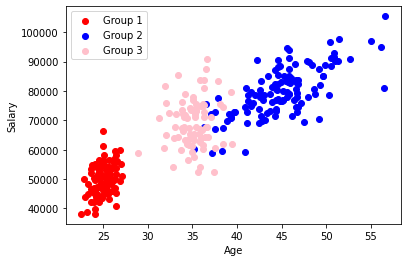

In [12]:
# Plot the sample data
group_1_colour, group_2_colour, group_3_colour ='red','blue', 'pink'
plt.xlabel('Age',fontsize=10)
plt.ylabel("Salary",fontsize=10) 

plt.scatter(group_1_ages,group_1_salaries,c=group_1_colour,label="Group 1")
plt.scatter(group_2_ages,group_2_salaries,c=group_2_colour,label="Group 2")
plt.scatter(group_3_ages,group_3_salaries,c=group_3_colour,label="Group 3")

plt.legend(loc='upper left')
plt.show()

### Save data to Aerospike

In [13]:
# Turn the above records into a Data Frame
# First of all, create an array of arrays
inputBuf = []

for  i in range(0, len(ages)) :
     id = i + 1 # Avoid counting from zero
     name = "Individual: {:03d}".format(id)
     # Note we need to make sure values are typed correctly
     # salary will have type numpy.float64 - if it is not cast as below, an error will be thrown
     age = float(ages[i])
     salary = int(salaries[i])
     inputBuf.append((id, name,age,salary))

# Convert to an RDD 
inputRDD = spark.sparkContext.parallelize(inputBuf)
       
# Convert to a data frame using a schema
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("age", DoubleType(), True),
    StructField("salary",IntegerType(), True)
])

inputDF=spark.createDataFrame(inputRDD,schema)

#Write the data frame to Aerospike, the id field is used as the primary key
inputDF \
.write \
.mode('overwrite') \
.format("aerospike")  \
.option("aerospike.set", "salary_data")\
.option("aerospike.updateByKey", "id") \
.save()

### Using Spark SQL syntax to insert data

In [14]:
#Aerospike DB needs a Primary key for record insertion. Hence, you must identify the primary key column 
#using for example .option(“aerospike.updateByKey”, “id”), where “id” is the name of the column that you’d 
#like to be the Primary key, while loading data from the DB.  

insertDFWithSchema=spark \
.read \
.format("aerospike") \
.schema(schema) \
.option("aerospike.set", "salary_data") \
.option("aerospike.updateByKey", "id") \
.load()

sqlView="inserttable"


#
# V2 datasource doesn't allow insert into a view. 
#
insertDFWithSchema.createTempView(sqlView)
spark.sql("select * from inserttable").show()

+---+---------------+------------------+------+
| id|           name|               age|salary|
+---+---------------+------------------+------+
|239|Individual: 239|34.652141285212814| 61747|
|101|Individual: 101| 46.53337694047585| 89019|
|194|Individual: 194| 45.57430980213645| 94548|
| 31|Individual: 031| 25.24920420954561| 54312|
|139|Individual: 139| 38.84745269824981| 69645|
| 14|Individual: 014|25.590430778495463| 51513|
|142|Individual: 142|  42.5606479932568| 80357|
|272|Individual: 272| 33.97918907293991| 66496|
| 76|Individual: 076|25.457857266022874| 46214|
|147|Individual: 147|43.186823515795496| 70158|
| 79|Individual: 079|25.887490702675912| 48162|
| 96|Individual: 096|24.084761701659602| 46328|
|132|Individual: 132|  50.3039623703105| 78746|
| 10|Individual: 010|25.082338749020728| 58345|
|141|Individual: 141| 43.67491677796685| 79076|
|140|Individual: 140|43.065120467057845| 78500|
|160|Individual: 160| 54.98712625322743| 97029|
|112|Individual: 112| 37.09568187885065|

## Load data into a DataFrame without specifying any Schema (uses schema inference)

In [15]:
# Create a Spark DataFrame by using the Connector Schema inference mechanism
# The fields preceded with __ are metadata fields - key/digest/expiry/generation/ttl
# By default you just get everything, with no column ordering, which is why it looks untidy
# Note we don't get anything in the 'key' field as we have not chosen to save as a bin.
# Use .option("aerospike.sendKey", True) to do this

loadedDFWithoutSchema = (
    spark.read.format("aerospike") \
    .option("aerospike.set", "salary_data") \
    .load()
)

loadedDFWithoutSchema.show(10)

+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|               age|           name|salary| id|
+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
| null|[03 50 2E 7F 70 9...|378341961|           2|2591999|34.652141285212814|Individual: 239| 61747|239|
| null|[0F 10 1A 93 B1 E...|378341961|           2|2591999| 45.57430980213645|Individual: 194| 94548|194|
| null|[04 C0 5E 9A 68 5...|378341961|           2|2591999| 46.53337694047585|Individual: 101| 89019|101|
| null|[1A E0 A8 A0 F2 3...|378341961|           2|2591999| 25.24920420954561|Individual: 031| 54312| 31|
| null|[23 20 78 35 5D 7...|378341961|           2|2591998| 38.84745269824981|Individual: 139| 69645|139|
| null|[35 00 8C 78 43 F...|378341961|           2|2591998|25.590430778495463|Individual: 014| 51513| 14|
| null|[37 00 6D 21 08 9...|378341961|        

## Load data into a DataFrame using user specified schema 

In [16]:
# If we explicitly set the schema, using the previously created schema object
# we effectively type the rows in the Data Frame

loadedDFWithSchema=spark \
.read \
.format("aerospike") \
.schema(schema) \
.option("aerospike.set", "salary_data").load()

loadedDFWithSchema.show(5)

+---+---------------+------------------+------+
| id|           name|               age|salary|
+---+---------------+------------------+------+
|239|Individual: 239|34.652141285212814| 61747|
|101|Individual: 101| 46.53337694047585| 89019|
|194|Individual: 194| 45.57430980213645| 94548|
| 31|Individual: 031| 25.24920420954561| 54312|
|139|Individual: 139| 38.84745269824981| 69645|
+---+---------------+------------------+------+
only showing top 5 rows



## Sampling from Aerospike DB

- Sample specified number of records from Aerospike to considerably reduce data movement between Aerospike and the Spark clusters. Depending on the aerospike.partition.factor setting, you may get more records than desired. Please use this property in conjunction with Spark `limit()` function to get the specified number of records. The sample read is not randomized, so sample more than you need and use the Spark `sample()` function to randomize if you see fit. You can use it in conjunction with `aerospike.recordspersecond` to control the load on the Aerospike server while sampling.

- For more information, please see [documentation](https://docs.aerospike.com/docs/connect/processing/spark/configuration.html) page.

In [17]:
#number_of_spark_partitions (num_sp)=2^{aerospike.partition.factor}
#total number of records = Math.ceil((float)aerospike.sample.size/num_sp) * (num_sp) 
#use lower partition factor for more accurate sampling
setname="py_input_data"
sample_size=101

df3=spark.read.format("aerospike") \
.option("aerospike.partition.factor","2") \
.option("aerospike.set",setname) \
.option("aerospike.sample.size","101") \
.load()

df4=spark.read.format("aerospike") \
.option("aerospike.partition.factor","6") \
.option("aerospike.set",setname) \
.option("aerospike.sample.size","101") \
.load()

#Notice that more records were read than requested due to the underlying partitioning logic related to the partition factor as described earlier, hence we use Spark limit() function additionally to return the desired number of records.
count3=df3.count()
count4=df4.count()


#Note how limit got only 101 records from df4.
dfWithLimit=df4.limit(101)
limitCount=dfWithLimit.count()

print("count3= ", count3, " count4= ", count4, " limitCount=", limitCount)

count3=  104  count4=  113  limitCount= 101


## Working with Collection Data Types (CDT) in Aerospike

### Save JSON into Aerospike using a schema

In [18]:
# Schema specification
aliases_type = StructType([
    StructField("first_name",StringType(),False),
    StructField("last_name",StringType(),False)
])

id_type = StructType([
    StructField("first_name",StringType(),False), 
    StructField("last_name",StringType(),False), 
    StructField("aliases",ArrayType(aliases_type),False)
])

street_adress_type = StructType([
    StructField("street_name",StringType(),False), 
    StructField("apt_number",IntegerType(),False)
])

address_type = StructType([
    StructField("zip",LongType(),False), 
    StructField("street",street_adress_type,False), 
    StructField("city",StringType(),False)
])

workHistory_type = StructType([
    StructField ("company_name",StringType(),False),
    StructField( "company_address",address_type,False),
    StructField("worked_from",StringType(),False)
])

person_type = StructType([
    StructField("name",id_type,False),
    StructField("SSN",StringType(),False),
    StructField("home_address",ArrayType(address_type),False),
    StructField("work_history",ArrayType(workHistory_type),False)
])

# JSON data location
complex_data_json="resources/nested_data.json"

# Read data in using prepared schema
cmplx_data_with_schema=spark.read.schema(person_type).json(complex_data_json)

# Save data to Aerospike
cmplx_data_with_schema \
.write \
.mode('overwrite') \
.format("aerospike")  \
.option("aerospike.writeset", "complex_input_data") \
.option("aerospike.updateByKey", "SSN") \
.save()

### Retrieve CDT from Aerospike into a DataFrame using schema 

In [19]:
loadedComplexDFWithSchema=spark \
.read \
.format("aerospike") \
.option("aerospike.set", "complex_input_data") \
.schema(person_type) \
.load() 
loadedComplexDFWithSchema.show(5)

+--------------------+-----------+--------------------+--------------------+
|                name|        SSN|        home_address|        work_history|
+--------------------+-----------+--------------------+--------------------+
|[Carrie, Collier,...|611-70-8032|[[14908, [Frankli...|[[Russell Group, ...|
|[Ashley, Davis, [...|708-19-4933|[[44679, [Duarte ...|[[Gaines LLC, [57...|
|[Anthony, Dalton,...|466-55-4994|[[48032, [Mark Es...|[[Mora, Sherman a...|
|[Jennifer, Willia...|438-70-6995|[[6917, [Gates Vi...|[[Cox, Olsen and ...|
|[Robert, Robinson...|561-49-6700|[[29209, [Hernand...|[[Frye, Mckee and...|
+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows



## Data Exploration with Aerospike 

In [20]:
import pandas
import matplotlib
import matplotlib.pyplot as plt

#convert Spark df to pandas df
pdf = loadedDFWithSchema.toPandas()

# Describe the data

pdf.describe()

,id,age,salary
count,300.000000,300.000000,300.000000
mean,150.500000,35.671508,66952.626667
std,86.746758,8.985810,14876.009907
min,1.000000,22.513878,38148.000000
25%,75.750000,25.773766,53387.000000
50%,150.500000,35.651953,69062.500000
75%,225.250000,44.030919,78533.750000
max,300.000000,56.636219,105414.000000


22 57


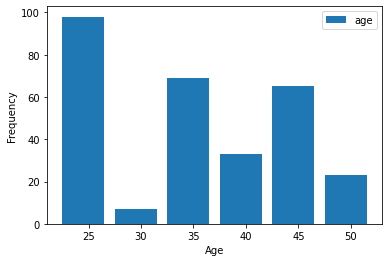

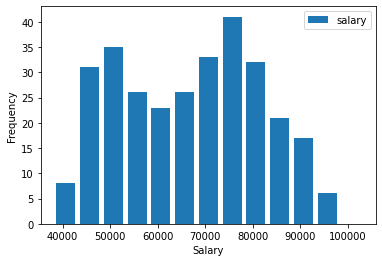

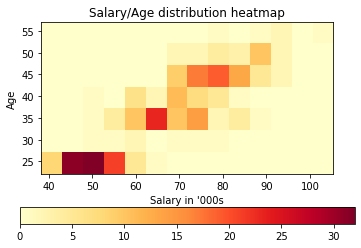

In [21]:
#Histogram - Age
age_min, age_max = int(np.amin(pdf['age'])), math.ceil(np.amax(pdf['age']))
age_bucket_size = 5
print(age_min,age_max)
pdf[['age']].plot(kind='hist',bins=range(age_min,age_max,age_bucket_size),rwidth=0.8)
plt.xlabel('Age',fontsize=10)
plt.legend(loc=None)
plt.show()

#Histogram - Salary
salary_min, salary_max = int(np.amin(pdf['salary'])), math.ceil(np.amax(pdf['salary']))
salary_bucket_size = 5000
pdf[['salary']].plot(kind='hist',bins=range(salary_min,salary_max,salary_bucket_size),rwidth=0.8)
plt.xlabel('Salary',fontsize=10)
plt.legend(loc=None)
plt.show()

# Heatmap
age_bucket_count = math.ceil((age_max - age_min)/age_bucket_size)
salary_bucket_count = math.ceil((salary_max - salary_min)/salary_bucket_size)

x = [[0 for i in range(salary_bucket_count)] for j in range(age_bucket_count)]
for i in range(len(pdf['age'])):
    age_bucket = math.floor((pdf['age'][i] - age_min)/age_bucket_size)
    salary_bucket = math.floor((pdf['salary'][i] - salary_min)/salary_bucket_size)
    x[age_bucket][salary_bucket] += 1

plt.title("Salary/Age distribution heatmap")
plt.xlabel("Salary in '000s")
plt.ylabel("Age")

plt.imshow(x, cmap='YlOrRd', interpolation='nearest',extent=[salary_min/1000,salary_max/1000,age_min,age_max],
           origin="lower")
plt.colorbar(orientation="horizontal")
plt.show()

 # Quering Aerospike Data using SparkSQL

### Note:
   1. Queries that involve Primary Key or Digest in the predicate trigger aerospike_batch_get()( https://www.aerospike.com/docs/client/c/usage/kvs/batch.html) and run extremely fast. For e.g. a query containing `__key` or `__digest` with, with no `OR` between two bins.
   2. All other queries may entail a full scan of the Aerospike DB if they can’t be converted to Aerospike batchget. 

## Queries that include Primary Key in the Predicate

With batch get queries we can apply filters on metadata columns such as `__gen` or `__ttl`. To do this, these columns should be exposed through the schema.


In [22]:
# Basic PKey query
batchGet1= spark \
.read \
.format("aerospike") \
.option("aerospike.set", "salary_data") \
.option("aerospike.keyType", "int") \
.load().where("__key = 100") \

batchGet1.show()
#Note ASDB only supports equality test with PKs in primary key query. 
#So, a where clause with "__key >10", would result in scan query!

+-----+--------------------+---------+------------+-------+-----------------+---------------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|              age|           name|salary| id|
+-----+--------------------+---------+------------+-------+-----------------+---------------+------+---+
|  100|[82 46 D4 AF BB 7...|378341961|           2|2591987|25.62963757719123|Individual: 100| 56483|100|
+-----+--------------------+---------+------------+-------+-----------------+---------------+------+---+



In [23]:
# Batch get, primary key based query
from pyspark.sql.functions import col
somePrimaryKeys= list(range(1,10))
someMoreKeys= list(range(12,14))
batchGet2= spark \
.read \
.format("aerospike") \
.option("aerospike.set", "salary_data") \
.option("aerospike.keyType", "int") \
.load().where((col("__key").isin(somePrimaryKeys)) | ( col("__key").isin(someMoreKeys))) 

batchGet2.show(5)

+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|               age|           name|salary| id|
+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
|   13|[27 B2 50 19 5B 5...|378341961|           2|2591985|24.945277952954463|Individual: 013| 47114| 13|
|    5|[CC 73 E2 C2 23 2...|378341961|           2|2591985| 26.41972973144744|Individual: 005| 53845|  5|
|    1|[85 36 18 55 4C B...|378341961|           2|2591985|25.395470523704972|Individual: 001| 48976|  1|
|    9|[EB 86 7C 94 AA 4...|378341961|           2|2591985| 24.04479361358856|Individual: 009| 39991|  9|
|    3|[B1 E9 BC 33 C7 9...|378341961|           2|2591985|26.918958635987867|Individual: 003| 59828|  3|
+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
only showing top 5 rows



### batchget query using `__digest`
   - `__digest` can have only two types `BinaryType`(default type) or `StringType`.
   - If schema is not provided and `__digest` is `StringType`, then set `aerospike.digestType` to `string`.
   - Records retrieved with `__digest` batchget call will have null primary key (i.e.`__key` is `null`).

In [24]:
#convert digests to a list of byte[]
digest_list=batchGet2.select("__digest").rdd.flatMap(lambda x: x).collect()

#convert digest to hex string for querying. Only digests of type hex string and byte[] array are allowed.
string_digest=[ ''.join(format(x, '02x') for x in m) for m in digest_list]

#option("aerospike.digestType", "string") hints to assume that __digest type is string in schema inference.
#please note that __key retrieved in this case is null. So be careful to use retrieved keys in downstream query!
batchGetWithDigest= spark \
.read \
.format("aerospike") \
.option("aerospike.set", "salary_data") \
.option("aerospike.digestType", "string") \
.load().where(col("__digest").isin(string_digest)) 
batchGetWithDigest.show()  


#digests can be mixed with primary keys as well
batchGetWithDigestAndKey= spark \
.read \
.format("aerospike") \
.option("aerospike.set", "salary_data") \
.option("aerospike.digestType", "string") \
.option("aerospike.keyType", "int") \
.load().where(col("__digest").isin(string_digest[0:1]) | ( col("__key").isin(someMoreKeys))) 
batchGetWithDigestAndKey.show()
#please note to the null in key columns in both dataframe

+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|               age|           name|salary| id|
+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
| null|27b250195b5a5ba13...|378341961|           2|2591977|24.945277952954463|Individual: 013| 47114| 13|
| null|cc73e2c2232b35c49...|378341961|           2|2591977| 26.41972973144744|Individual: 005| 53845|  5|
| null|853618554cb05c351...|378341961|           2|2591977|25.395470523704972|Individual: 001| 48976|  1|
| null|eb867c94aa487a039...|378341961|           2|2591977| 24.04479361358856|Individual: 009| 39991|  9|
| null|b1e9bc33c79b69e5c...|378341961|           2|2591977|26.918958635987867|Individual: 003| 59828|  3|
| null|5a4a6223f73814afe...|378341961|           2|2591977|24.065640693038556|Individual: 006| 55035|  6|
| null|db4ab2ffe4642f01c...|378341961|        

## Queries including non-primary key conditions

In [25]:
# This query will run as a scan, which will be slower
somePrimaryKeys= list(range(1,10))
scanQuery1= spark \
.read \
.format("aerospike") \
.option("aerospike.set", "salary_data") \
.option("aerospike.keyType", "int") \
.load().where((col("__key").isin(somePrimaryKeys)) | ( col("age") >50 ))

scanQuery1.show()

+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
|__key|            __digest| __expiry|__generation|  __ttl|               age|           name|salary| id|
+-----+--------------------+---------+------------+-------+------------------+---------------+------+---+
| null|[9A 80 6A A1 FC C...|378341961|           2|2591974|  50.3039623703105|Individual: 132| 78746|132|
| null|[EF A0 76 41 51 B...|378341961|           2|2591974| 54.98712625322743|Individual: 160| 97029|160|
| null|[6E 92 74 77 95 D...|378341961|           2|2591974| 56.51623471593584|Individual: 196| 80848|196|
| null|[71 65 79 9E 25 9...|378341961|           2|2591974|  50.4687163424899|Individual: 162| 96742|162|
| null|[7C 66 F5 9E 99 6...|378341961|           2|2591974| 50.57144124293668|Individual: 156| 88377|156|
| null|[7E A6 1C 30 4F 9...|378341961|           2|2591974| 50.58123004549132|Individual: 203| 91326|203|
| null|[AB AA F1 86 BF C...|378341961|        

## Pushdown [Aerospike Expressions](https://docs.aerospike.com/docs/guide/expressions/) from within a Spark API.

 - Make sure that you do not use no the WHERE clause or spark filters while querying
 - See [Aerospike Expressions](https://docs.aerospike.com/docs/guide/expressions/) for more information on how to construct expressions.
 - Contstructed expressions must be converted to Base64 before using them in the Spark API


In [26]:
scala_predexp= sc._jvm.com.aerospike.spark.utility.AerospikePushdownExpressions

#id % 5 == 0  => get rows where mod(col("id")) ==0
#Equvalent java Exp: Exp.eq(Exp.mod(Exp.intBin("a"), Exp.`val`(5)), Exp.`val`(0))
expIntBin=scala_predexp.intBin("id") # id is the name of column
expMODIntBinEqualToZero=scala_predexp.eq(scala_predexp.mod(expIntBin, scala_predexp.val(5)),scala_predexp.val(0))
expMODIntBinToBase64= scala_predexp.build(expMODIntBinEqualToZero).getBase64()
#expMODIntBinToBase64= "kwGTGpNRAqJpZAUA"
pushdownset = "py_input_data"


pushDownDF =spark\
        .read \
        .format("aerospike") \
        .schema(schema) \
        .option("aerospike.set", pushdownset) \
        .option("aerospike.pushdown.expressions", expMODIntBinToBase64) \
        .load()

pushDownDF.count() #should get 39 records, we have 199/5 records whose id bin is divisble by 5

39

In [27]:
pushDownDF.show(2)

+---+------+----+------+
| id|  name| age|salary|
+---+------+----+------+
| 10|name10|null|  null|
| 50|name50|null|  null|
+---+------+----+------+
only showing top 2 rows



## Parameters for tuning Aerospike / Spark performance

  - aerospike.partition.factor: number of logical aerospike partitions [0-15]
  - aerospike.maxthreadcount : maximum number of threads to use for writing data into Aerospike
  - aerospike.compression : compression of java client-server communication
  - aerospike.batchMax : maximum number of records per read request (default 5000)
  - aerospike.recordspersecond : same as java client

## Other useful parameters
  - aerospike.keyType : Primary key type hint for schema inference. Always set it properly if primary key type is not string  

See https://www.aerospike.com/docs/connect/processing/spark/reference.html for detailed description of the above properties


# Machine Learning using Aerospike / Spark

In this section we use the data we took from Aerospike and apply a clustering algorithm to it.

We assume the data is composed of multiple data sets having a Gaussian multi-variate distribution

We don't know how many clusters there are, so we try clustering based on the assumption there are 1 through 20.

We compare the quality of the results using the Bayesian Information Criterion - https://en.wikipedia.org/wiki/Bayesian_information_criterion and pick the best.
    
## Find Optimal Cluster Count    

In [28]:
from sklearn.mixture import GaussianMixture

# We take the data we previously 
ages=pdf['age']
salaries=pdf['salary']
#age_salary_matrix=np.matrix([ages,salaries]).T
age_salary_matrix=np.asarray([ages,salaries]).T

# Find the optimal number of clusters
optimal_cluster_count = 1
best_bic_score = GaussianMixture(1).fit(age_salary_matrix).bic(age_salary_matrix)

for count in range(1,20):
    gm=GaussianMixture(count)
    gm.fit(age_salary_matrix)
    if gm.bic(age_salary_matrix) < best_bic_score:
        best_bic_score = gm.bic(age_salary_matrix)
        optimal_cluster_count = count

print("Optimal cluster count found to be "+str(optimal_cluster_count))

Optimal cluster count found to be 4


## Estimate cluster distribution parameters
Next we fit our cluster using the optimal cluster count, and print out the discovered means and covariance matrix

In [29]:
gm = GaussianMixture(optimal_cluster_count)
gm.fit(age_salary_matrix)

estimates = []
# Index
for index in range(0,optimal_cluster_count):
    estimated_mean_age = round(gm.means_[index][0],2)
    estimated_mean_salary = round(gm.means_[index][1],0)
    estimated_age_std_dev = round(math.sqrt(gm.covariances_[index][0][0]),2)
    estimated_salary_std_dev = round(math.sqrt(gm.covariances_[index][1][1]),0)
    estimated_correlation = round(gm.covariances_[index][0][1] / ( estimated_age_std_dev * estimated_salary_std_dev ),3)
    row = [estimated_mean_age,estimated_mean_salary,estimated_age_std_dev,estimated_salary_std_dev,estimated_correlation]
    estimates.append(row)
    
pd.DataFrame(estimates,columns = ["Est Mean Age","Est Mean Salary","Est Age Std Dev","Est Salary Std Dev","Est Correlation"])    


,Est Mean Age,Est Mean Salary,Est Age Std Dev,Est Salary Std Dev,Est Correlation
0,47.24,87827.0,3.98,6091.0,0.735
1,25.05,49897.0,1.06,5185.0,0.398
2,44.37,76736.0,3.32,4534.0,0.415
3,35.43,68712.0,1.85,7966.0,-0.028


## Original Distribution Parameters

In [30]:
distribution_data_as_rows = []
for distribution in distribution_data:
    row = [distribution['age_mean'],distribution['salary_mean'],distribution['age_std_dev'],
                             distribution['salary_std_dev'],distribution['age_salary_correlation']]
    distribution_data_as_rows.append(row)

pd.DataFrame(distribution_data_as_rows,columns = ["Mean Age","Mean Salary","Age Std Dev","Salary Std Dev","Correlation"])

,Mean Age,Mean Salary,Age Std Dev,Salary Std Dev,Correlation
0,25,50000,1,5000,0.3
1,45,80000,4,8000,0.7
2,35,70000,2,9000,0.1


You can see that the algorithm provides good estimates of the original parameters

## Prediction

We generate new age/salary pairs for each of the distributions and look at how accurate the prediction is

In [31]:
def prediction_accuracy(model,age_salary_distribution,sample_size):
    # Generate new values
    new_ages,new_salaries = age_salary_sample(age_salary_distribution,sample_size)
    #new_age_salary_matrix=np.matrix([new_ages,new_salaries]).T
    new_age_salary_matrix=np.asarray([new_ages,new_salaries]).T
    # Find which cluster the mean would be classified into
    #mean = np.matrix([age_salary_distribution['age_mean'],age_salary_distribution['salary_mean']])
    #mean = np.asarray([age_salary_distribution['age_mean'],age_salary_distribution['salary_mean']])
    mean = np.asarray(np.matrix([age_salary_distribution['age_mean'],age_salary_distribution['salary_mean']]))
    mean_cluster_index = model.predict(mean)[0]
    # How would new samples be classified
    classification = model.predict(new_age_salary_matrix)
    # How many were classified correctly
    correctly_classified = len([ 1 for x in classification if x  == mean_cluster_index])
    return correctly_classified / sample_size

prediction_accuracy_results = [None for x in range(3)]
for index, age_salary_distribution in enumerate(distribution_data):
    prediction_accuracy_results[index] = prediction_accuracy(gm,age_salary_distribution,1000)

overall_accuracy = sum(prediction_accuracy_results)/ len(prediction_accuracy_results)
print("Accuracies for each distribution : "," ,".join(map('{:.2%}'.format,prediction_accuracy_results)))
print("Overall accuracy : ",'{:.2%}'.format(overall_accuracy))


Accuracies for each distribution :  100.00% ,60.20% ,98.00%
Overall accuracy :  86.07%


## aerolookup
 aerolookup allows you to look up records corresponding to a set of keys stored in a Spark DF, streaming or otherwise. It supports:
 
  - [Aerospike CDT](https://docs.aerospike.com/docs/guide/cdt.htmlarbitrary)
  - Quota and retry (these configurations are extracted from sparkconf) 
  - [Flexible schema](https://docs.aerospike.com/docs/connect/processing/spark/configuration.html#flexible-schemas). To enable, set `aerospike.schema.flexible` to true in the SparkConf object.
  - Aerospike Expressions Pushdown (Note: This must be specified through SparkConf object.)


In [32]:
alias = StructType([StructField("first_name", StringType(), False),
                    StructField("last_name", StringType(), False)])
name = StructType([StructField("first_name", StringType(), False),
                   StructField("aliases", ArrayType(alias), False)])
street_adress = StructType([StructField("street_name", StringType(), False),
                            StructField("apt_number", IntegerType(), False)])
address = StructType([StructField("zip", LongType(), False),
                      StructField("street", street_adress, False),
                      StructField("city", StringType(), False)])
work_history = StructType([StructField("company_name", StringType(), False),
                          StructField("company_address", address, False),
                          StructField("worked_from", StringType(), False)])

output_schema = StructType([StructField("name", name, False),
                          StructField("SSN", StringType(), False),
                         StructField("home_address", ArrayType(address), False)])

ssns = [["825-55-3247"], ["289-18-1554"], ["756-46-4088"], 
        ["525-31-0299"], ["456-45-2200"], ["200-71-7765"]]

#Create a set of PKs whose records you'd like to look up in the Aerospike database
customerIdsDF=spark.createDataFrame(ssns,["SSN"])

from pyspark.sql import SQLContext

scala2_object= sc._jvm.com.aerospike.spark.PythonUtil #Import the scala object
gateway_df=scala2_object.aerolookup(customerIdsDF._jdf,  #Please note ._jdf
                                    'SSN',
                                    'complex_input_data', #complex_input_data is the set in Aerospike database that you are using to look up the keys stored in SSN DF
                                    output_schema.json(),
                                    'test')
aerolookup_df=pyspark.sql.DataFrame(gateway_df,spark._wrapped)  
#Note the wrapping of java object into python.sql.DataFrame 


In [33]:
aerolookup_df.show()

+--------------------+-----------+--------------------+
|                name|        SSN|        home_address|
+--------------------+-----------+--------------------+
|[Gary, [[Cameron,...|825-55-3247|[[66428, [Kim Mil...|
|[Megan, [[Robert,...|289-18-1554|[[81551, [Archer ...|
|[Melanie, [[Justi...|756-46-4088|[[61327, [Jeanett...|
|[Lisa, [[William,...|525-31-0299|[[98337, [Brittne...|
|[Ryan, [[Jonathon...|456-45-2200|[[97077, [Davis D...|
|[Lauren, [[Shaun,...|200-71-7765|[[6813, [Johnson ...|
+--------------------+-----------+--------------------+

